# Running the ADHunter Notebook with Explicit 1HE

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)
os.chdir("../adhunter")

Global seed set to 0


In [2]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
# fn = "data/OrthologTilingDFwActivities_20220131.csv"
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()


df = pd.read_csv(fn)
df["Activity"] = df["Activity"].fillna(0.0)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# 
df = df.dropna(subset=df.columns[:-1], axis=0)


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

In [3]:
# Store train test splits in the df and save the whole df
df["Set"] = "train"
df.loc[df.iloc[test_idx].index, "Set"] = "test"
df.loc[df.iloc[val_idx].index, "Set"] = "val"
df.to_csv(fn.split(".csv")[0] + "_train_test_val.csv")

In [4]:
pd.read_csv(fn.split(".csv")[0] + "_train_test_val.csv")

,Unnamed: 0,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,Stdev_BYS4_BioReps,Set
0,0,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,20,-986,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,50849.756535,15910.995586,val
1,1,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,25,-981,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,22153.464394,NaN,test
2,2,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,30,-976,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,25911.890423,13364.539799,val
3,3,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,35,-971,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,22446.773651,17698.744045,val
4,4,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,40,-966,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,51501.398208,5355.696567,test
...,...,...,...,...,...,...,...,...
18891,88363,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,215,91,VAVKRARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKS,42259.516373,554.550689,train
18892,88364,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,220,96,ARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQ,15158.577492,4316.422793,train
18893,88365,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,225,101,AARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAM,85443.165260,NaN,train
18894,88366,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224,230,106,RRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAMAQTSM,21800.948266,NaN,train


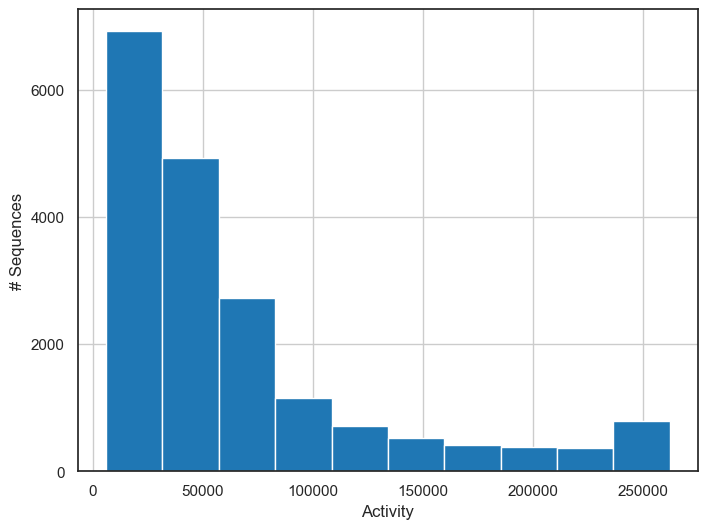

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [6]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

Global seed set to 0


### One-Hot Development stuff (DELETE)

In [37]:
import torch.nn.functional as Fun
# print(one_hot(arr).shape)

def one_hot_custom(arr, n_classes):
    n_classes = 20
    valid_mask = (arr >=0) & (arr < n_classes)
    if valid_mask.all():
        out = Fun.one_hot(arr)
    else:
        classes = range(n_classes)
        rows, cols = arr.shape
        out = torch.zeros((rows, cols, n_classes))
        for i in range(rows):
            for j in range(cols):
                if arr[i, j] in classes:
                    out[i, j, arr[i, j]] = 1
                print(arr[i, j])
                out[i, j] = torch.zeros(n_classes)
    return out

one_hot_custom(X_train, n_classes=20)

tensor([[[0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0,

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
from sklearn.preprocessing import OneHotEncoder

from actpred.models import ResBlock

class ActCNNOneHot(nn.Module):
    """ADHunter model class. Similar to ActCNN, but with explicit 
    one-hot encoding fed into a linear layer to facilitate 
    interpretability.
    """
    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40):
        super(ActCNNOneHot, self).__init__()
        self.emb = nn.Linear(20, hidden, bias=False)
        self.conv_init = nn.Conv1d(in_channels=hidden,
                                   kernel_size=kernel_size,
                                   out_channels=hidden,
                                   padding="same")
        self.res_blocks = nn.ModuleList([
            ResBlock(hidden, kernel_size, dilation)
            for _ in range(num_res_blocks)
        ])
        self.pool = nn.MaxPool1d(kernel_size=seq_len)
        self.lin = nn.Linear(hidden, 1)

    def forward(self, X):
        # X = Fun.one_hot(X, num_classes=20).float()
        X = self.one_hot_custom(X, num_classes=20).float()
        out = self.emb(X)
        out = out.transpose(2, 1)
        out = self.conv_init(out)
        for res_block in self.res_blocks:
            out = res_block(out)
        out = self.pool(out).squeeze()
        out = self.lin(out)
        return out
    
    def one_hot_custom(self, arr, num_classes:int):
        """Custom one hot encoding to allow encoding invalid indices 
        as all 0 vectors.

        Args:
            arr (torch.tensor): Array of token indices corresponding to desired one hot index. 
                Input value >= num_classes to encode all 0's.
            num_classes (int): _description_

        Returns:
            torch.tensor: one hot encoded array
        """        
        valid_mask = (arr >=0) & (arr < num_classes)
        if valid_mask.all():
            out = Fun.one_hot(arr, num_classes=num_classes)
        else:
            classes = range(num_classes)
            rows, cols = arr.shape
            out = torch.zeros((rows, cols, num_classes))
            for i in range(rows):
                for j in range(cols):
                    if arr[i, j] in classes:
                        out[i, j, arr[i, j]] = 1
                    out[i, j] = torch.zeros(num_classes)
        return out


class ActCNNOneHotSystem(pl.LightningModule):
    """Wrapper for ActCNNOneHot model.
    """
    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40,
                 weight_decay=1e-2):
        super(ActCNNOneHotSystem, self).__init__()
        self.save_hyperparameters()
        self.wd = weight_decay
        self.model = ActCNNOneHot(hidden,
                            kernel_size,
                            dilation,
                            seq_len=seq_len,
                            num_res_blocks=num_res_blocks)
        self.loss_fn = nn.MSELoss()

        self.rmse = MeanSquaredError(squared=False)
        self.pearsonr = PearsonCorrCoef()
        self.spearmanr = SpearmanCorrCoef()
        self.metrics = {
            "rmse": self.rmse,
            "pearsonr": self.pearsonr,
            "spearmanr": self.spearmanr
        }

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=1e-3,
                                     weight_decay=self.wd)
        return optimizer

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = self.loss_fn(y_pred, y)
        return {
            "loss": loss,
            "y_target": y.view(-1),
            "y_pred": y_pred.detach().view(-1),
        }

    def training_epoch_end(self, train_step_outputs):
        y_preds = [d['y_pred'] for d in train_step_outputs]
        y_targets = [d['y_target'] for d in train_step_outputs]
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        train_loss = self.metrics['rmse'](y_preds, y_targets)
        for metric_name, metric in self.metrics.items():
            metric_name = "train_" + metric_name
            self.log(metric_name, metric(y_preds, y_targets))
        return

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        return (y_pred.view(-1), y.view(-1))

    def validation_epoch_end(self, val_step_outputs):
        y_preds, y_targets = zip(*val_step_outputs)
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        val_loss = self.metrics['rmse'](y_preds, y_targets)
        self.log("val_loss", val_loss)
        for metric_name, metric in self.metrics.items():
            metric_name = "val_" + metric_name
            print(metric_name, metric(y_preds, y_targets).item(), flush=True)
            self.log(metric_name, metric(y_preds, y_targets))
        return val_loss

In [ ]:
# class ActCNN(nn.Module):

#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40,
#                  one_hot=True):
#         super(ActCNN, self).__init__()
#         self.one_hot_explicit = one_hot
#         if self.one_hot_explicit:
#             self.emb = nn.Linear(20, hidden, bias=False)
#         else:
#             self.emb = nn.Embedding(20, embedding_dim=hidden, dtype=torch.float32)
#         self.conv_init = nn.Conv1d(in_channels=hidden,
#                                    kernel_size=kernel_size,
#                                    out_channels=hidden,
#                                    padding="same")
#         self.res_blocks = nn.ModuleList([
#             ResBlock(hidden, kernel_size, dilation)
#             for _ in range(num_res_blocks)
#         ])
#         self.pool = nn.MaxPool1d(kernel_size=seq_len)
#         self.lin = nn.Linear(hidden, 1)

#     def forward(self, X):
#         if self.one_hot_explicit:
#             X = self.one_hot_custom(X, num_classes=20).float()
#         out = self.emb(X)
#         out = out.transpose(2, 1)
#         out = self.conv_init(out)
#         for res_block in self.res_blocks:
#             out = res_block(out)
#         out = self.pool(out).squeeze()
#         out = self.lin(out)
#         return out
    
#     def one_hot_custom(self, arr, num_classes:int):
#         """Custom one hot encoding to allow encoding invalid indices 
#         as all 0 vectors.

#         Args:
#             arr (torch.tensor): Array of token indices corresponding to desired one hot index. 
#                 Input value >= num_classes to encode all 0's.
#             num_classes (int): _description_

#         Returns:
#             torch.tensor: one hot encoded array
#         """        
#         valid_mask = (arr >=0) & (arr < num_classes)
#         if valid_mask.all():
#             out = Fun.one_hot(arr, num_classes=num_classes)
#         else:
#             classes = range(num_classes)
#             rows, cols = arr.shape
#             out = torch.zeros((rows, cols, num_classes))
#             for i in range(rows):
#                 for j in range(cols):
#                     if arr[i, j] in classes:
#                         out[i, j, arr[i, j]] = 1
#                     out[i, j] = torch.zeros(num_classes)
#         return out


# class ActCNNSystem(pl.LightningModule):

#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40,
#                  weight_decay=1e-2,
#                  one_hot=True):
#         super(ActCNNSystem, self).__init__()
#         self.save_hyperparameters()
#         self.wd = weight_decay
#         self.model = ActCNN(hidden,
#                             kernel_size,
#                             dilation,
#                             seq_len=seq_len,
#                             num_res_blocks=num_res_blocks,
#                             one_hot=one_hot)
#         self.loss_fn = nn.MSELoss()

#         self.rmse = MeanSquaredError(squared=False)
#         self.pearsonr = PearsonCorrCoef()
#         self.spearmanr = SpearmanCorrCoef()
#         self.metrics = {
#             "rmse": self.rmse,
#             "pearsonr": self.pearsonr,
#             "spearmanr": self.spearmanr
#         }

#     def forward(self, x):
#         return self.model(x)

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(),
#                                      lr=1e-3,
#                                      weight_decay=self.wd)
#         return optimizer

#     def training_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         loss = self.loss_fn(y_pred, y)
#         return {
#             "loss": loss,
#             "y_target": y.view(-1),
#             "y_pred": y_pred.detach().view(-1),
#         }

#     def training_epoch_end(self, train_step_outputs):
#         y_preds = [d['y_pred'] for d in train_step_outputs]
#         y_targets = [d['y_target'] for d in train_step_outputs]
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         train_loss = self.metrics['rmse'](y_preds, y_targets)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "train_" + metric_name
#             self.log(metric_name, metric(y_preds, y_targets))
#         return

#     def validation_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         return (y_pred.view(-1), y.view(-1))

#     def validation_epoch_end(self, val_step_outputs):
#         y_preds, y_targets = zip(*val_step_outputs)
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         val_loss = self.metrics['rmse'](y_preds, y_targets)
#         self.log("val_loss", val_loss)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "val_" + metric_name
#             print(metric_name, metric(y_preds, y_targets).item(), flush=True)
#             self.log(metric_name, metric(y_preds, y_targets))
#         return val_loss


In [40]:
# encoder = OneHotEncoder(handle_unknown="ignore", categories=[range(20)], sparse_output=False)
# print(X_train.shape)
# encoder.fit_transform(X_train.reshape(-1, 1)).reshape(14653, 40, 20).shape
# # torch.tensor(encoder.fit_transform(X_train).toarray(), device=X_train.device)
# one_hot(baseline_null, num_classes=20)

## Train the Model

In [25]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3, one_hot=True)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 179.54it/s]val_rmse 0.9874640703201294
val_pearsonr 0.15594547986984253
val_spearmanr 0.13505488634109497
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 134/134 [00:01<00:00, 76.42it/s, loss=0.278, v_num=47]val_rmse 0.5141299962997437
val_pearsonr 0.8648849725723267
val_spearmanr 0.7404506802558899
Epoch 1: 100%|██████████| 134/134 [00:01<00:00, 72.96it/s, loss=0.207, v_num=47]val_rmse 0.47542455792427063
val_pearsonr 0.8896670341491699
val_spearmanr 0.7833960652351379
Epoch 2: 100%|██████████| 134/134 [00:01<00:00, 76.78it/s, loss=0.196, v_num=47]val_rmse 0.4990004599094391
val_pearsonr 0.8937642574310303
val_spearmanr 0.804794430732727
Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 76.67it/s, loss=0.217, v_num=47]val_rmse 0.48025593161582947
val_pearsonr 0.8987537622451782
val_spearmanr 0.8096617460250854
Epoch 4: 100%|██████████| 134/134 [00:01<00:00, 77.50it/s, loss=0.178, v_num=47]val_rmse 0.5047551393508911
val_pearsonr 0.8983009457588196
val_spearmanr 0.8111426830291748
Epoch 5: 100%|██████████| 134/134 [00:01<00:00, 74.31it/s, loss=0.211, v_num=47]val_rmse 0.49417412281036377
val_pearsonr 0.9097726941

In [27]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(model.cpu().state_dict(), "adhunter_1he.pt")

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [31]:
null_output = model(torch.zeros(1, 40) + 21)
print(null_output.item())
null_output_activity = scaler.inverse_transform(
    null_output.detach().numpy().reshape(-1, 1)
    ).item()
print(null_output_activity)
# model.model.one_hot_custom(torch.zeros(1, 40) + 21, 20).shape

0.10752509534358978
72599.515625


In [32]:
# Load model 
model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

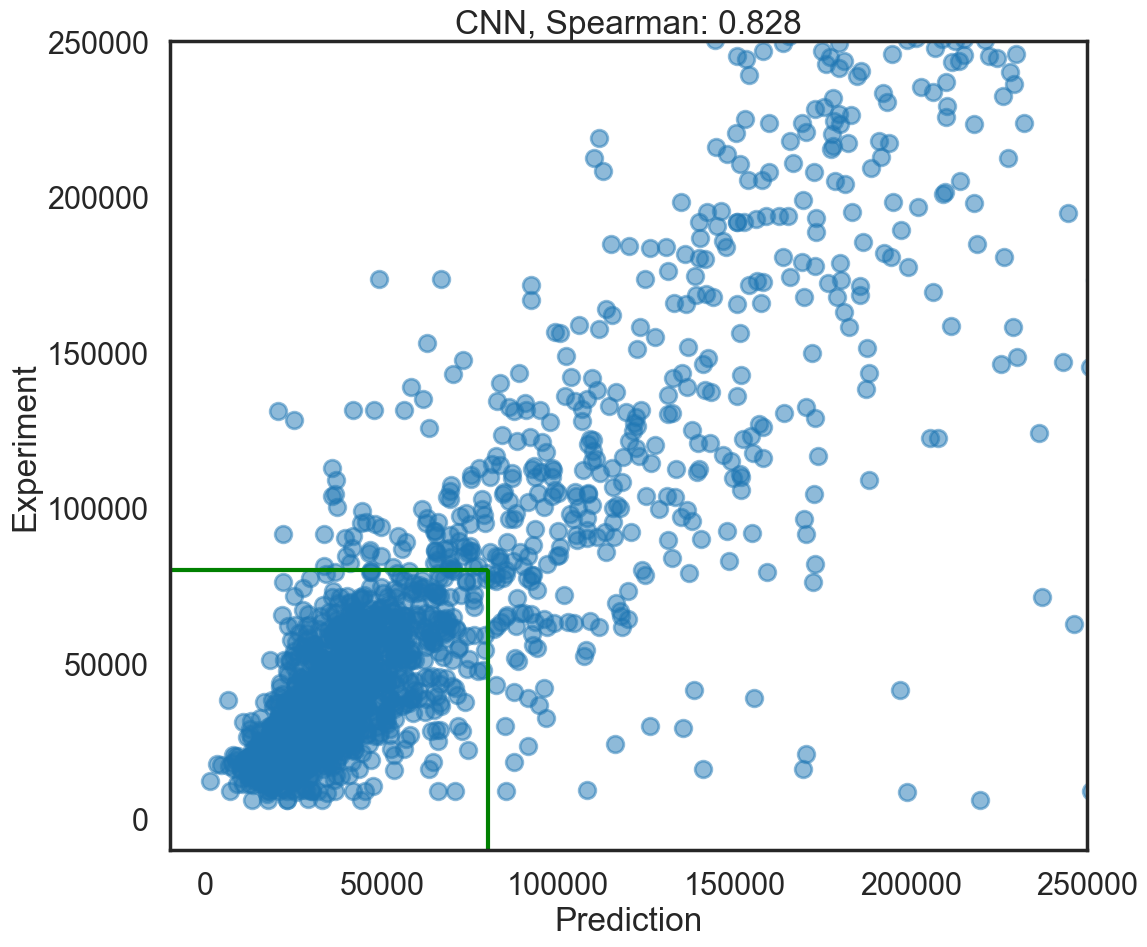

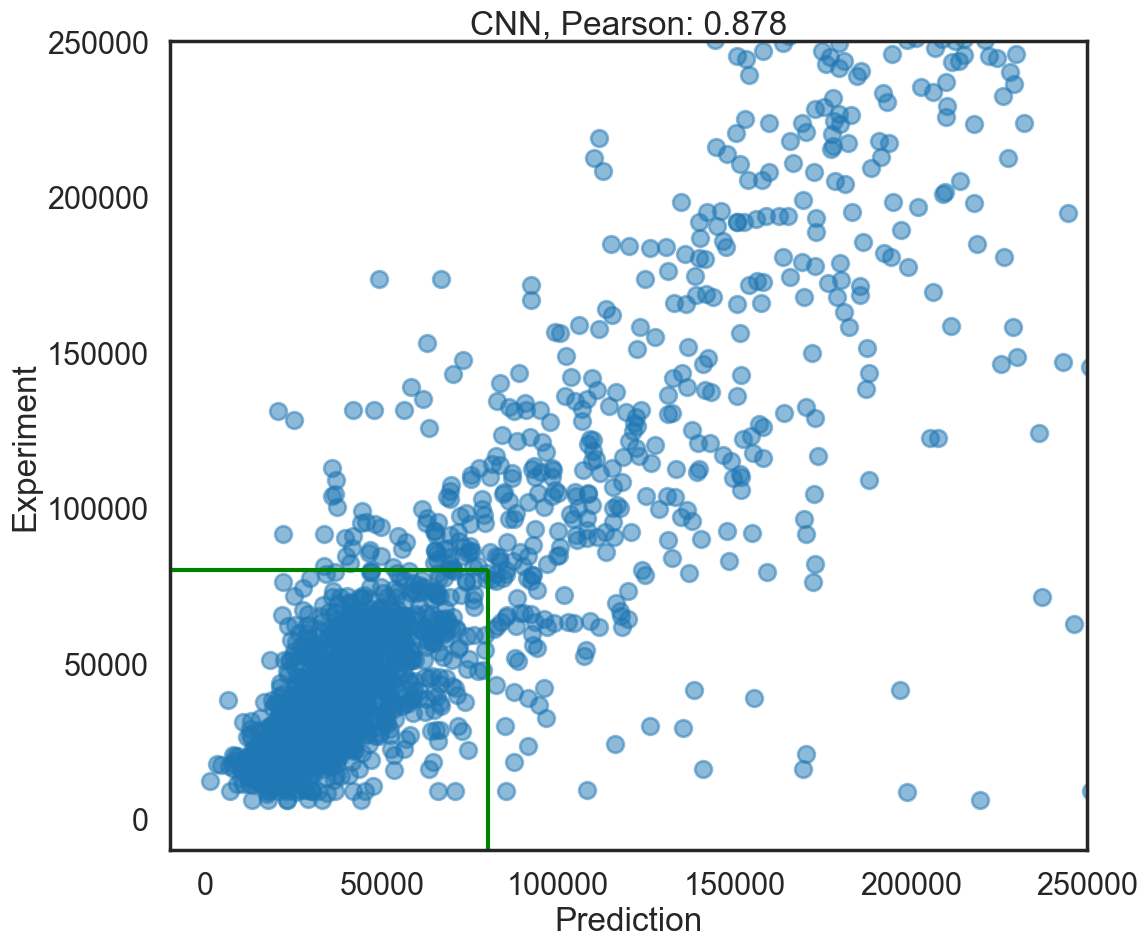

In [33]:
test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)


def plot_corr(method="spearman"):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
    if method == "spearman":
        corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
        ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
    elif method == "pearson":
        corr = pearsonr(y_test_hat_unscaled, y_test_unscaled).correlation
        ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Pearson: {corr:.3f}")
    ax.set(xlim=(-10000, 250_000), ylim=(-10000, 250_000))
    plt.tight_layout()
    plt.axvline(x=80_000, c='green', ymax=0.345)
    plt.axhline(y=80_000, c='green', xmax=0.345)
    plt.show()

plot_corr("spearman")
plot_corr("pearson")

# Captum DeepLIFT

In [34]:
# weak = "PTPEAFAADTITRFQTTANTQVSSPCSFRSIERNQFRRSS"
# strong = "IEESMDECIRWLENPFLNQFIAGFDLIGEEATEKHPLIYH"
# weak = "EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ"
strong = "ASYNPVVSNNASASEVRGVPAPEDDFDDAMNLWMGLHGPK"
def encode(seq):
    assert len(seq) == 40, "Sequence must be 40 AA!"
    return torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64)


strongAD = encode(strong)
# Load in a WxxLF AD with WxxLF removed (which is known to not activate) as weak AD for reference
gcn4_df = pd.read_csv("../data/Gcn4Array_Design.csv", index_col=0)
display(gcn4_df.loc[gcn4_df["Name"].str.contains("GCN4_CAAD40")])
gcn4 = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_0", "ADseq"].unique().item()
gcn4AD = encode(gcn4)

weak = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_WLF_A_0", "ADseq"].unique().item() # WLF only > A
weakAD = encode(weak)

,ADseq,Name,ArrayDNA
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...


In [76]:
from captum.attr import LayerDeepLift
sns.reset_defaults()

sample_input = torch.randint(0, 20, (1, 40), dtype=torch.int64)
baseline_null = torch.zeros(1, 40, dtype=torch.int64) + 21
baseline_gs = encode("".join(["GS" for _ in range(20)]))

# baseline = weakAD
# baseline = torch.zeros_like(sample_input, dtype=torch.int64)
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=False,)

def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True)
    attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap="bwr", center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

In [36]:
# 1: ATTRIBUTE WITH GS BASELINE
# Get attributions for a random peptide
attr_gs_baseline_df = get_attr(dl, sample_input, baseline=baseline_gs)
# Get attributions for train and test sets
attr_train_gs_baseline_df = get_attr(dl, X_train, baseline=baseline_gs)
attr_test_gs_baseline_df = get_attr(dl, X_test, baseline=baseline_gs)
# Get attributions for full dataset
X_full = torch.tensor(X)
attr_full_gs_baseline_df = get_attr(dl, X_full, baseline=baseline_gs)
attr_strong_gs_baseline_df = get_attr(dl, strongAD, baseline=baseline_gs)
attr_weak_gs_baseline_df = get_attr(dl, weakAD, baseline=baseline_gs)


In [58]:
def rescale(x):
    out = model(x).detach().numpy().reshape(-1, 1)
    return scaler.inverse_transform(out).item()

gs_pred = '%.2f' % rescale(baseline_gs)
weak_pred = '%.2f' % rescale(weakAD)
null_pred = '%.2f' % rescale(baseline_null)

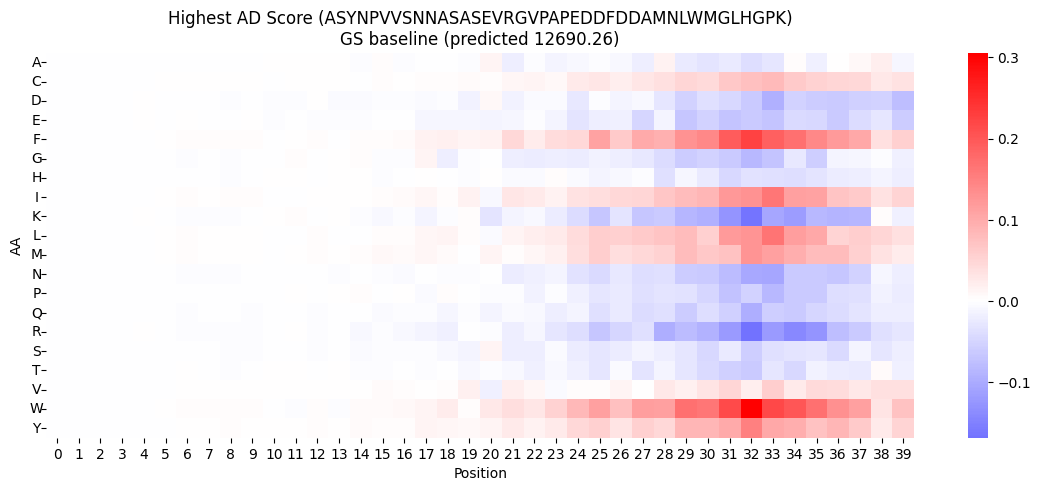

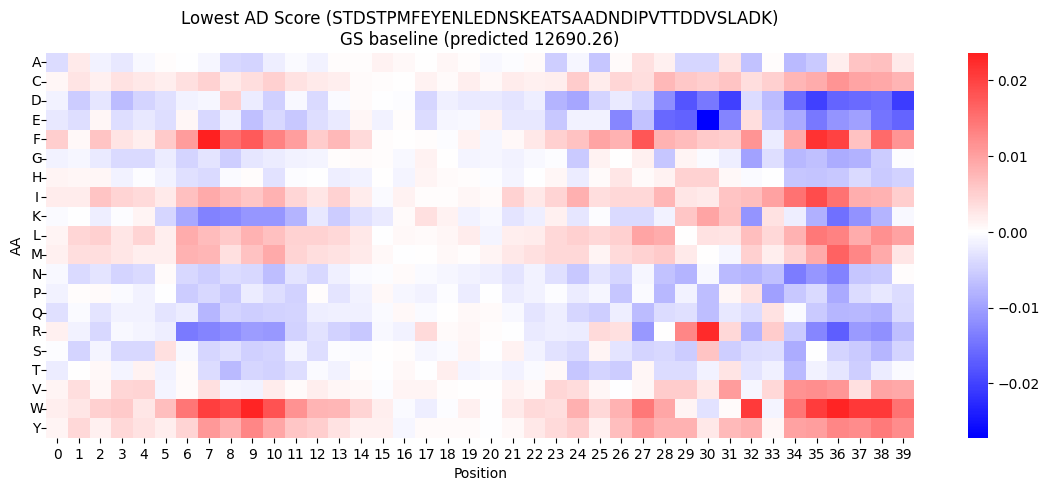

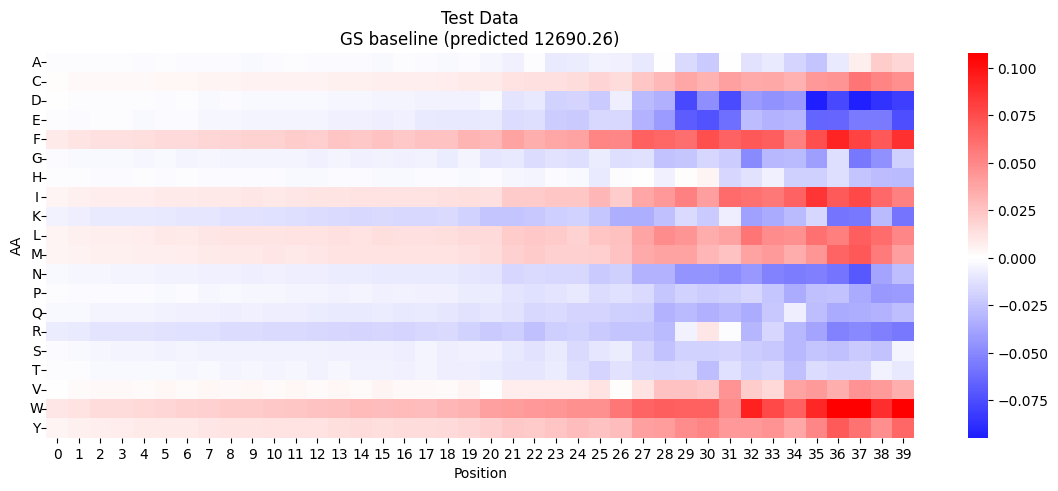

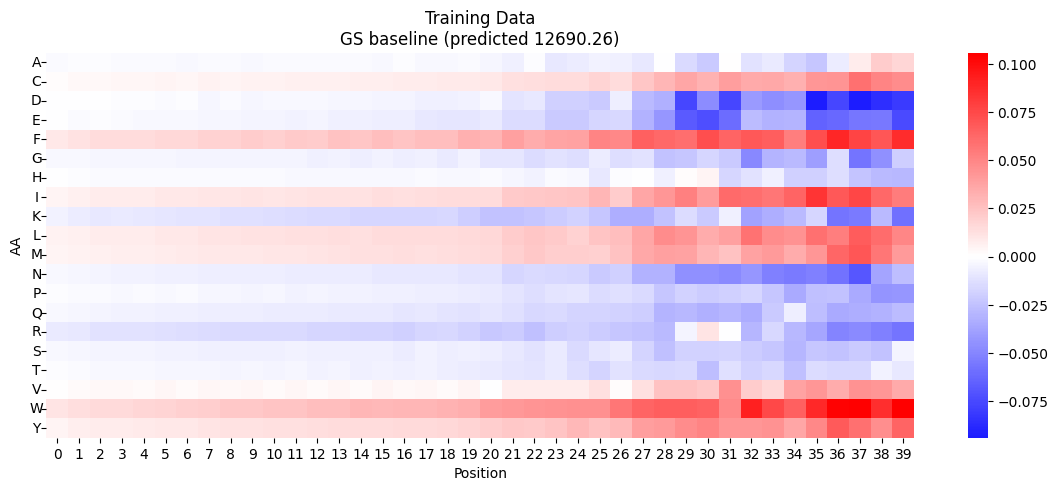

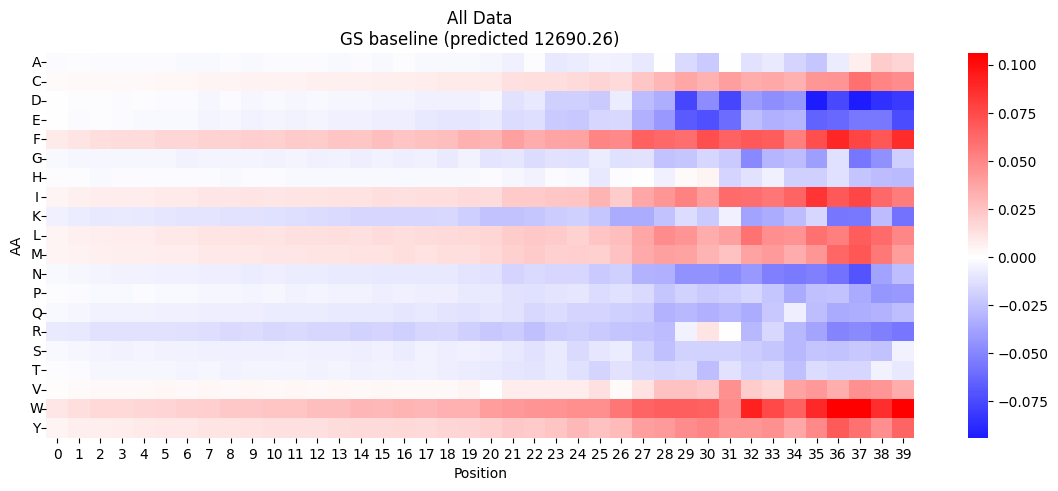

In [59]:
plot_attr(attr_strong_gs_baseline_df, title=f"Highest AD Score ({strong})\nGS baseline (predicted {gs_pred})")
plt.show()
plot_attr(attr_weak_gs_baseline_df, title=f"Lowest AD Score ({weak})\nGS baseline (predicted {gs_pred})")
plt.show()
plot_attr(attr_test_gs_baseline_df, title=f"Test Data\nGS baseline (predicted {gs_pred})")
plt.show()
plot_attr(attr_train_gs_baseline_df, title=f"Training Data\nGS baseline (predicted {gs_pred})")
plt.show()
plot_attr(attr_full_gs_baseline_df, title=f"All Data\nGS baseline (predicted {gs_pred})")
plt.show()

In [48]:
# 2: ATTRIBUTE WITH WEAK AD AS BASELINE
# Get attributions for a random peptide
attr_weakbaseline_df = get_attr(dl, sample_input, baseline=weakAD)
# Get attributions for train and test sets
attr_train_weakbaseline_df = get_attr(dl, X_train, baseline=weakAD)
attr_test_weakbaseline_df = get_attr(dl, X_test, baseline=weakAD)
# Get attributions for full dataset
X_full = torch.tensor(X)
attr_full_weakbaseline_df = get_attr(dl, X_full, baseline=weakAD)
attr_strong_weakbaseline_df = get_attr(dl, strongAD, baseline=weakAD)
attr_weak_weakbaseline_df = get_attr(dl, weakAD, baseline=weakAD)

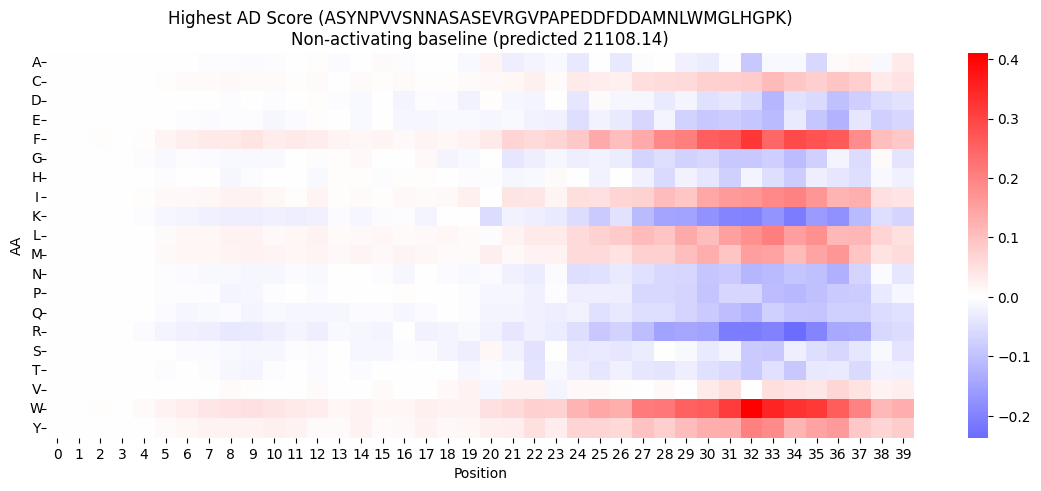

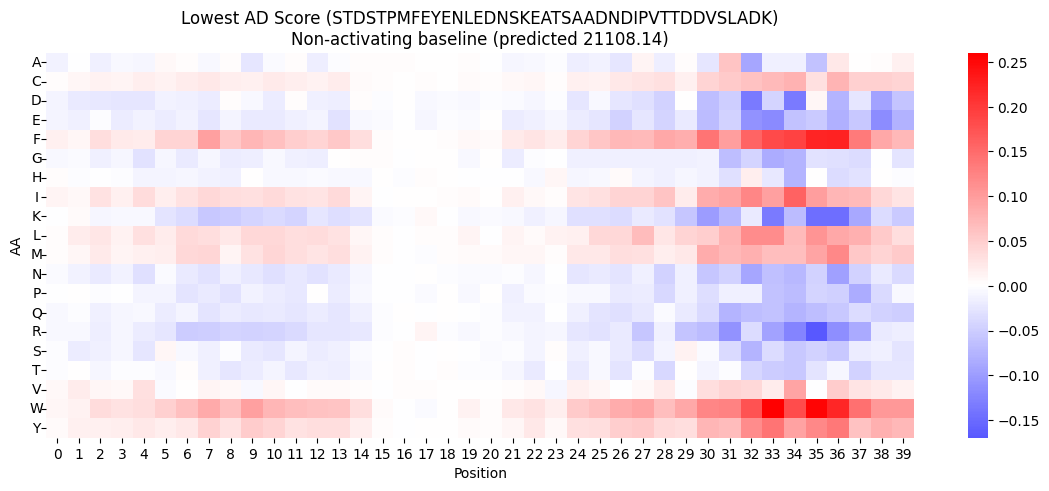

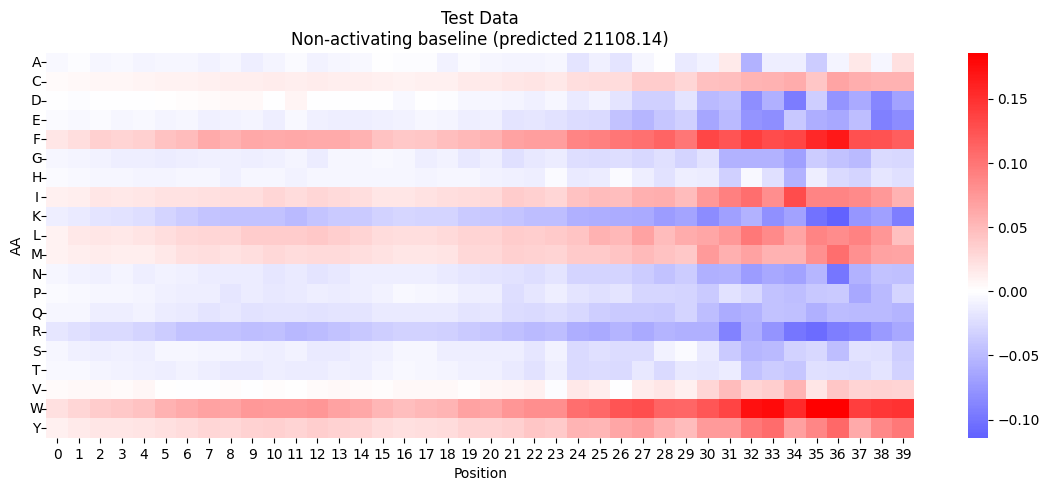

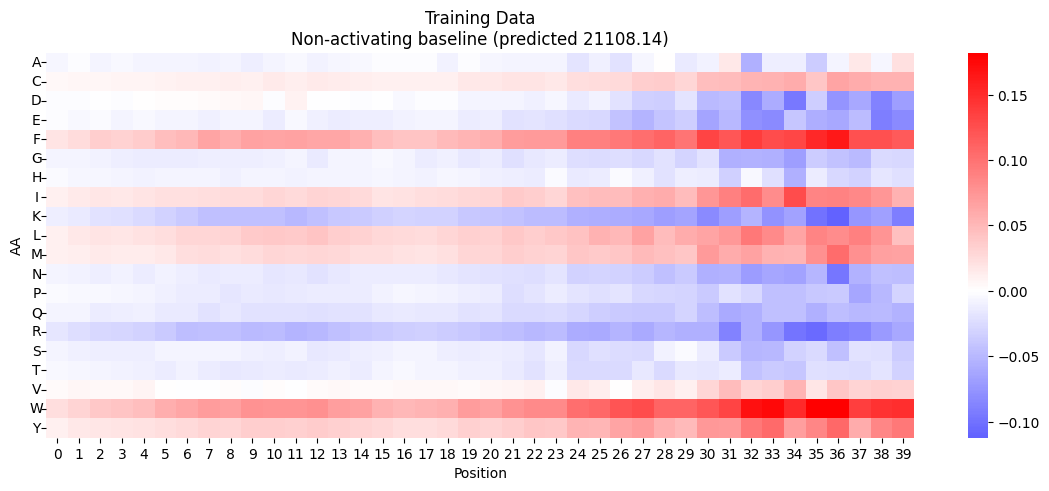

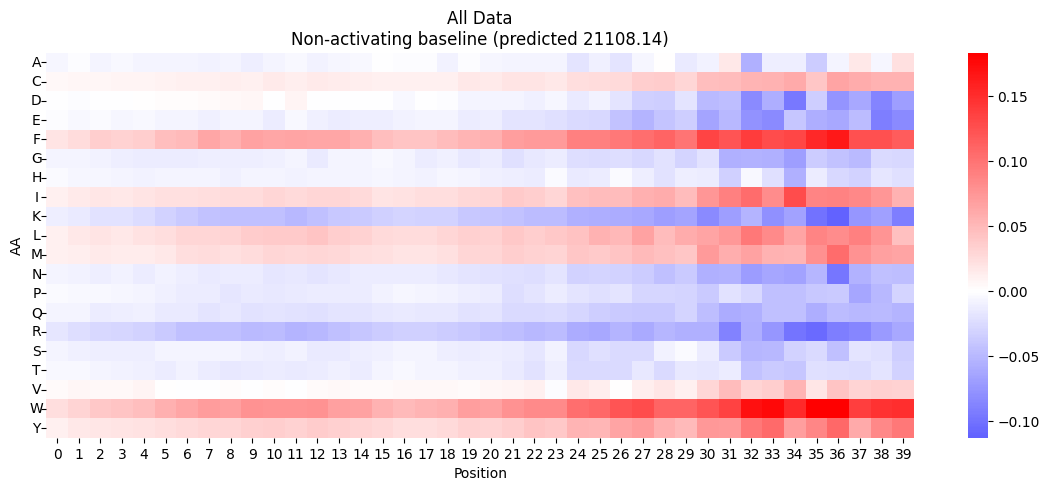

In [60]:
plot_attr(attr_strong_weakbaseline_df, title=f"Highest AD Score ({strong})\nNon-activating baseline (predicted {weak_pred})")
plt.show()
plot_attr(attr_weak_weakbaseline_df, title=f"Lowest AD Score ({weak})\nNon-activating baseline (predicted {weak_pred})")
plt.show()
plot_attr(attr_test_weakbaseline_df, title=f"Test Data\nNon-activating baseline (predicted {weak_pred})")
plt.show()
plot_attr(attr_train_weakbaseline_df, title=f"Training Data\nNon-activating baseline (predicted {weak_pred})")
plt.show()
plot_attr(attr_full_weakbaseline_df, title=f"All Data\nNon-activating baseline (predicted {weak_pred})")
plt.show()

In [61]:
# 3: ATTRIBUTE WITH 0 VECTOR AS BASELINE
# Get attributions for a random peptide
attr_nullbaseline_df = get_attr(dl, sample_input, baseline=baseline_null)
# Get attributions for train and test sets
attr_train_nullbaseline_df = get_attr(dl, X_train, baseline=baseline_null)
attr_test_nullbaseline_df = get_attr(dl, X_test, baseline=baseline_null)
# Get attributions for full dataset
X_full = torch.tensor(X)
attr_full_nullbaseline_df = get_attr(dl, X_full, baseline=baseline_null)
attr_strong_nullbaseline_df = get_attr(dl, strongAD, baseline=baseline_null)
attr_weak_nullbaseline_df = get_attr(dl, weakAD, baseline=baseline_null)

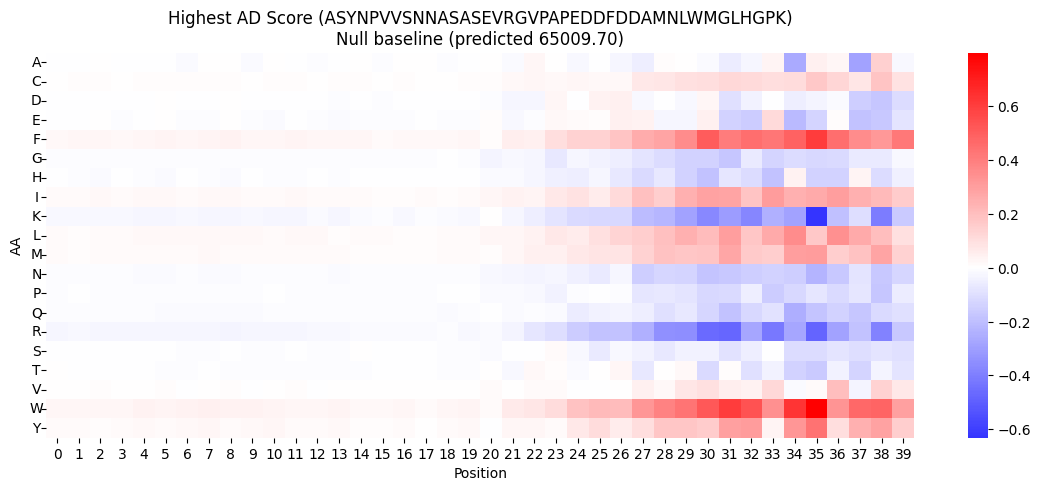

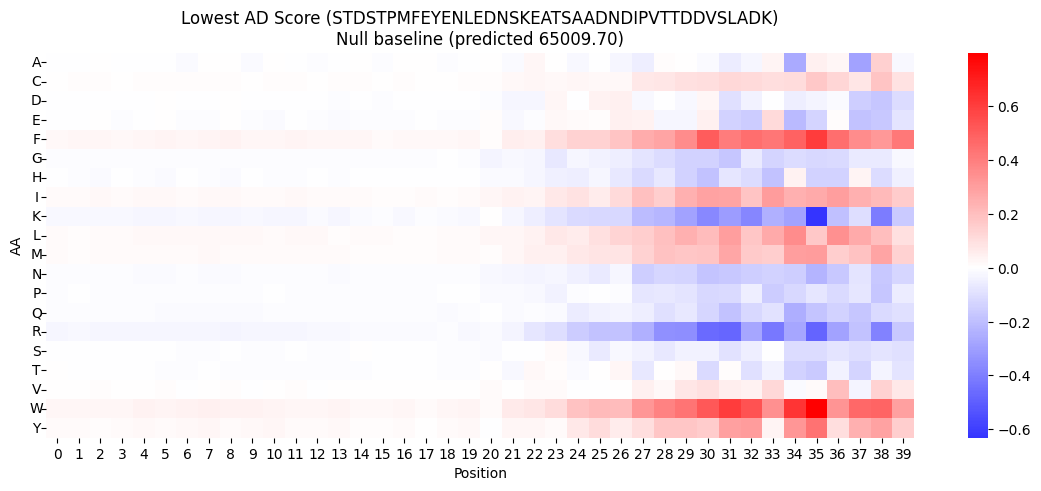

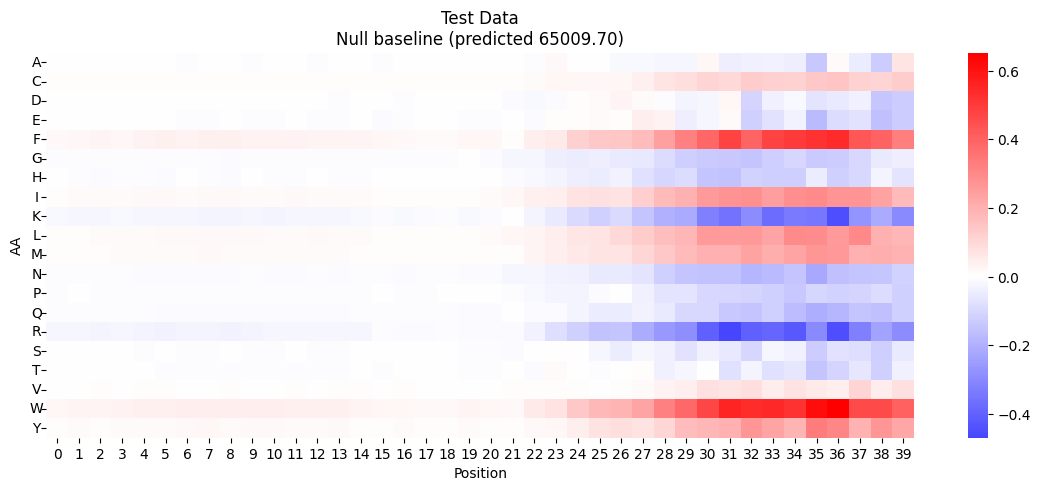

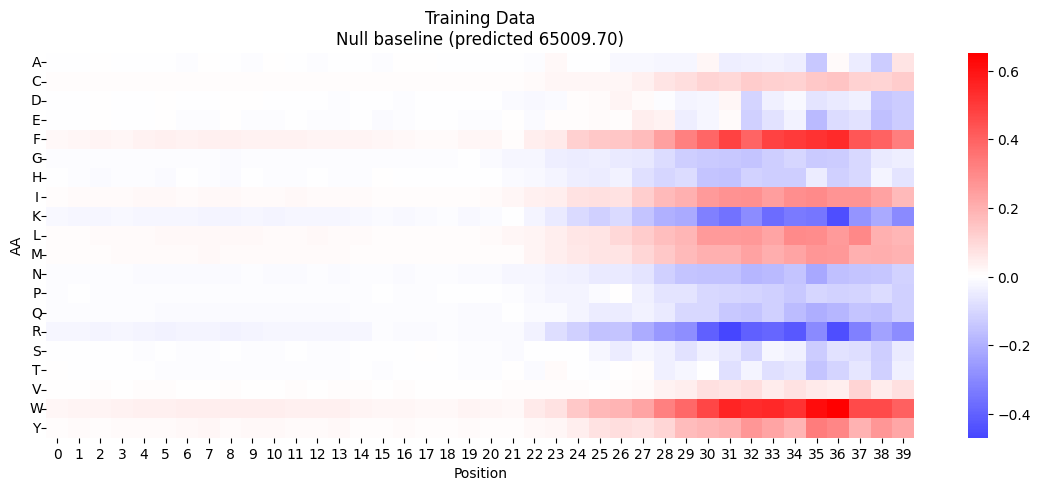

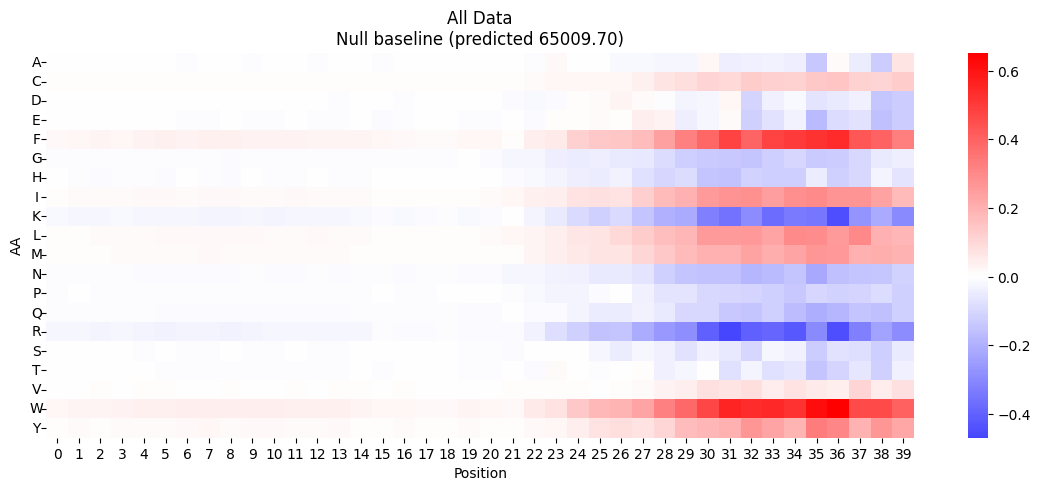

In [62]:
plot_attr(attr_strong_nullbaseline_df, title=f"Highest AD Score ({strong})\nNull baseline (predicted {null_pred})")
plt.show()
plot_attr(attr_weak_nullbaseline_df, title=f"Lowest AD Score ({weak})\nNull baseline (predicted {null_pred})")
plt.show()
plot_attr(attr_test_nullbaseline_df, title=f"Test Data\nNull baseline (predicted {null_pred})")
plt.show()
plot_attr(attr_train_nullbaseline_df, title=f"Training Data\nNull baseline (predicted {null_pred})")
plt.show()
plot_attr(attr_full_nullbaseline_df, title=f"All Data\nNull baseline (predicted {null_pred})")
plt.show()

In [42]:
resn_props = {
    "acidic": ["D", "E"],
    "hydrophobic": ["A", "V", "I", "L", "M", "F", "Y", "W"],
    "aromatic": ["F", "Y", "W"]
}


## TODO
- Importance | Activator
- Importance | Acidic resn present
- Importance | Hydrophobic resn present
- Importance | Aromatic resn present

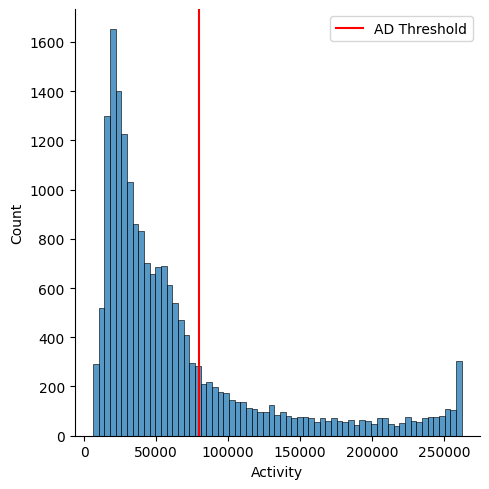

In [64]:
sns.displot(df["Activity"])#, kind="kde")
ad_threshold = 80_000
plt.axvline(ad_threshold, c='r', label="AD Threshold")
plt.legend()
plt.show()

In [66]:
X_ad = torch.tensor(X[np.where(df["Activity"] >= ad_threshold)[0]])

att_ad_df_weakad = get_attr(dl, X_ad, baseline=weakAD)
att_ad_df_gs = get_attr(dl, X_ad, baseline=baseline_gs)
att_ad_df_null = get_attr(dl, X_ad, baseline=baseline_null)
# dl_mbi = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
# attr_ = dl_mbi.attribute(X_ad, baselines=weakAD, attribute_to_layer_input=True)
# attr_ad_df = pd.DataFrame(attr_.detach().numpy().mean(axis=0)).T
# attr_ad_df.index = list(alphabet)
# # attr_ad_df = get_attr(dl, X_ad, baseline)

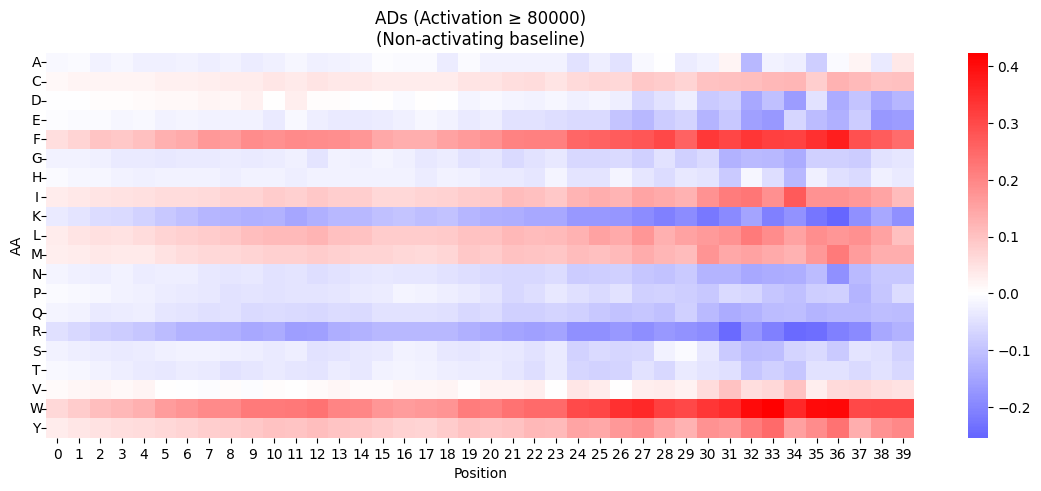

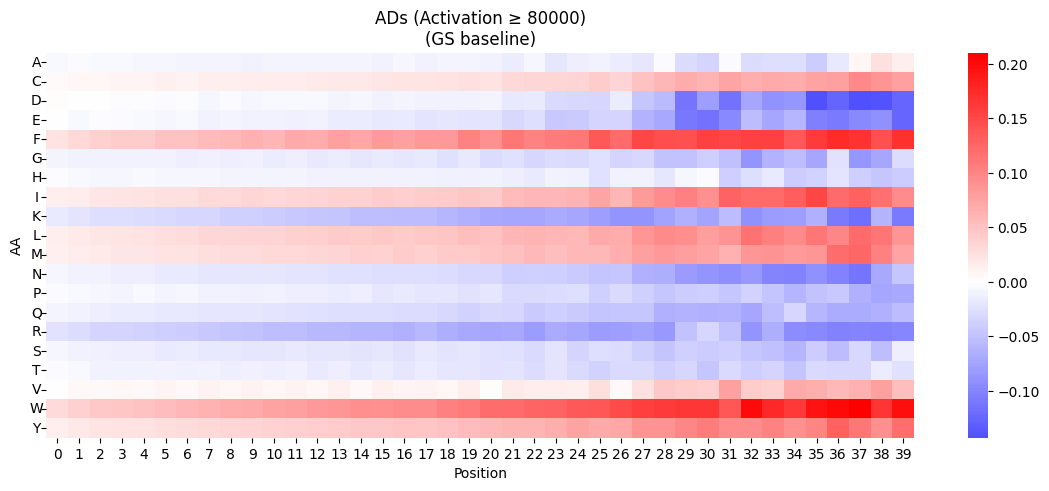

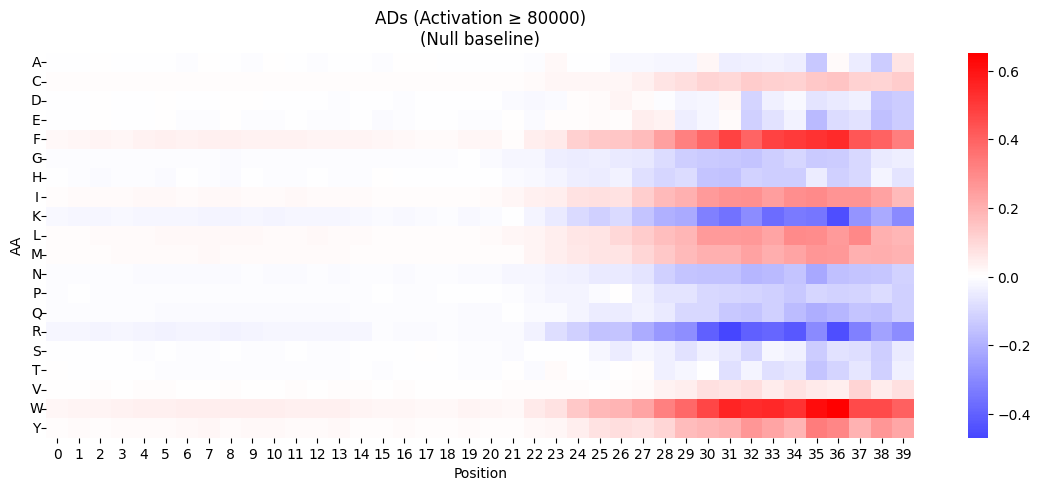

In [67]:
plot_attr(att_ad_df_weakad, title=f"ADs (Activation \u2265 {ad_threshold})\n(Non-activating baseline)")
plt.show()
plot_attr(att_ad_df_gs, title=f"ADs (Activation \u2265 {ad_threshold})\n(GS baseline)")
plt.show()
plot_attr(att_ad_df_null, title=f"ADs (Activation \u2265 {ad_threshold})\n(Null baseline)")
plt.show()

In [77]:
dl_inputwise = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
att_ad_df_weakad_inputwise = get_attr(dl_inputwise, X_ad, baseline=weakAD)
att_ad_df_gs_inputwise = get_attr(dl_inputwise, X_ad, baseline=baseline_gs)
att_ad_df_null_inputwise = get_attr(dl_inputwise, X_ad, baseline=baseline_null)

In [86]:
# plot_attr(att_ad_df_null_inputwise)
# plt.show()
dl_inputwise.attribute(strongAD, baseline_null, attribute_to_layer_input=True) 
dl.attribute(strongAD, baseline_null, attribute_to_layer_input=True) 

tensor([[[-1.2268e-03,  5.2715e-03, -1.5675e-03, -3.7709e-03,  2.1811e-02,
          -6.4218e-03, -4.4199e-03,  1.2550e-02, -1.7802e-02,  1.4210e-02,
           1.4819e-02, -8.4098e-03, -5.6010e-03, -7.7596e-03, -2.5822e-02,
          -4.3891e-03,  8.6618e-04,  2.1643e-03,  2.9317e-02,  1.3334e-02],
         [-2.2621e-03,  6.0711e-03, -1.6845e-03, -2.8364e-03,  2.5870e-02,
          -6.0042e-03, -7.7571e-03,  1.4817e-02, -2.1914e-02,  1.0675e-02,
           1.1179e-02, -9.4231e-03, -3.3430e-03, -6.0839e-03, -2.0722e-02,
          -3.2919e-03, -3.2323e-03,  3.5575e-03,  3.0086e-02,  1.4427e-02],
         [ 8.0488e-04,  7.0163e-03,  1.0897e-04,  4.3239e-03,  2.7047e-02,
          -9.5409e-03, -1.1695e-02,  1.7865e-02, -2.1939e-02,  1.5800e-02,
           1.2059e-02, -9.5455e-03, -1.0575e-02, -6.8797e-03, -2.9808e-02,
          -1.5610e-03, -4.0701e-03,  6.3412e-03,  3.0127e-02,  8.0885e-03],
         [-5.2213e-03,  5.5076e-03, -3.2568e-03, -6.7429e-03,  2.2614e-02,
          -6.5604e-03,

In [48]:
# from torchviz import make_dot

# dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
# dot.format = 'png'
# dot.render('simple_net')
# dot

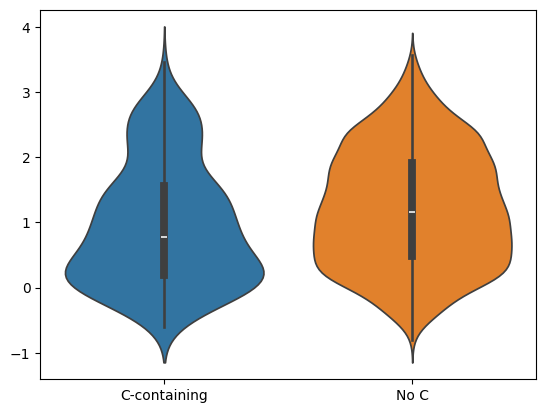

In [105]:
df_ad = df[df["Activity"] >= ad_threshold]
contains_c = df_ad["Seq"].str.contains("C")
df_ad_c = df_ad[contains_c]
df_ad_no_c = df_ad[~contains_c]

X_ad_c = torch.stack(df_ad_c["Seq"].apply(encode).values.tolist()).squeeze()
X_ad_no_c = torch.stack(df_ad_no_c["Seq"].apply(encode).values.tolist()).squeeze()

sns.violinplot({
    "C-containing": model(X_ad_c).detach().numpy().flatten(),
    "No C": model(X_ad_no_c).detach().numpy().flatten(),})
plt.show()
# dl.attribute(X_ad_c, baselines=X_ad_no_c, attribute_to_layer_input=True)

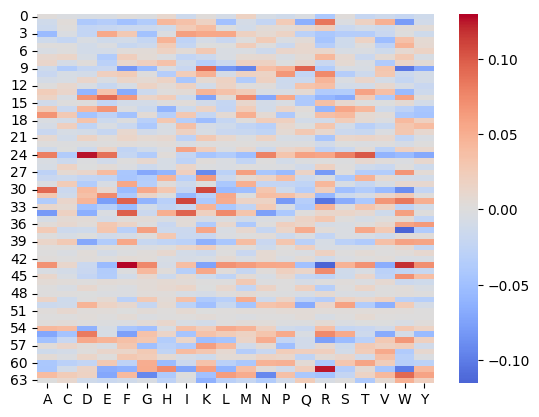

In [134]:
emb_wts = pd.DataFrame(model.model.emb.weight.detach().numpy())
emb_wts.columns = list(alphabet)
sns.heatmap(
    emb_wts,
    cmap="coolwarm", center=0)
# plt.xticks(range(20), labels=list(alphabet))
plt.show()

In [140]:
print(emb_wts.sum()["C"] * pd.Series(list(megaseq)).value_counts()["C"])
emb_wts.sum() * pd.Series(list(megaseq)).value_counts()

-237.98265121877193


A      793.355012
C     -237.982651
D    -1618.575088
E    -4662.938667
F    -3535.224118
G    -7290.836526
H     -457.927954
I     -136.738279
K     1276.070007
L   -11074.398030
M     3059.488226
N     4237.443963
P    20944.910936
Q    -6649.740689
R    -4406.642249
S   -22677.939709
T     8971.489316
V    -7705.306645
W     1111.029517
Y     -499.835042
dtype: float64

In [137]:
megaseq = "".join(df["Seq"].tolist())
pd.Series(list(megaseq)).value_counts()

S    104363
P     74250
A     66234
L     55218
T     51606
D     46349
R     43059
Q     39066
V     37337
E     36157
N     34656
F     33448
G     33193
K     25162
I     23734
H     17906
M     13506
Y     11804
W      5542
C      3250
Name: count, dtype: int64

A   -0.527555
C    1.727425
D   -0.686217
E   -0.954635
F    6.587409
G   -1.742084
H   -1.606929
I    3.846102
K   -4.745018
L    3.757612
M    3.293863
N   -2.455592
P   -1.529188
Q   -2.088336
R   -5.569640
S   -1.137952
T   -0.959799
V    0.946242
W    7.715571
Y    3.426352
dtype: float32


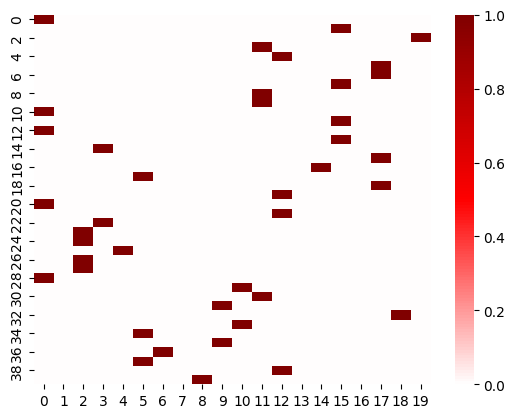

In [ ]:
print(attr_strong_nullbaseline_df.sum(axis=1))

# model(strongAD) - model(baseline_null)
model.model.one_hot_custom(strongAD, 20).shape
strong_1he = model.model.one_hot_custom(strongAD, 20).float()
null_1he = model.model.one_hot_custom(baseline_null, 20)

strong_emb = model.model.emb(strong_1he).squeeze().detach().numpy()
null_emb = model.model.emb(null_1he).squeeze().detach().numpy()

sns.heatmap(strong_1he.squeeze() - null_1he.squeeze(), cmap='seismic', center=0)
plt.show()
# model.model.emb(model.model.one_hot_custom(strongAD, 20)) - 